# PROJECT 1: Higgs Boson

First, we import the usual import needed.

In [453]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Library only used for observing the data in a more visual way.
import pandas as pd

import methods as md

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the training data into feature matrix, class labels, and event ids:

Let's import the data:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
tX.shape

(250000, 30)

We store the data in a pandas DataFrame to see more easily how they look like, but we are not going to use this specific library for other reasons.

In [4]:
df = pd.concat([pd.DataFrame({'labels': y, 'ids': ids}), pd.DataFrame(tX)], axis=1)
df_indexed = df.set_index(['ids'])
df_indexed.head(8)

,labels,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
ids,,,,,,,,,,,,,,,,,,,,,
100000,1.0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
100001,-1.0,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,-1.916,164.546,1.0,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226
100002,-1.0,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,-2.186,260.414,1.0,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251
100003,-1.0,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,0.060,86.062,0.0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
100004,-1.0,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-0.871,53.131,0.0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
100005,-1.0,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,2.237,282.849,3.0,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
100006,1.0,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,-1.443,294.074,2.0,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
100007,1.0,154.916,10.418,94.714,29.169,-999.000,-999.000,-999.000,2.897,1.526,...,-1.761,187.299,1.0,30.638,-0.715,-1.724,-999.000,-999.000,-999.000,30.638


We observed that many entries are filled by the value *-999*, which represent a lack of information. Theses values disturb our statistical calculations. Therefore it is very useful to clean the data before performing any further computations.

## Cleaning data set

Let's define a function that take as input the matrix of the different features *tX* for all the samples and return the same matrix matrix after some cleaning have been performed.

In order to *"clean"* our data, we are first going to replace the *-999* values by the mean of the features on all the sample for which we have an information. With this process, we preserve our statistical result of the influence of theses outliers.

In [5]:
from helpers import *

def clean_data(tx):
    nbrRows = tx.shape[0]
    nbrColunms = tx.shape[1]
    tx_temp = np.zeros((nbrRows,nbrColunms))
    modified_columns = [False] * nbrColunms
    
    for columnID in range(nbrColunms):
        currentColumn = tx[:,columnID].copy()
        
        # extract indices with -999 values
        nanIndices = []

        for rowID in range(nbrRows):
            if currentColumn[rowID] == -999.000:
                nanIndices.append(rowID)
                modified_columns[columnID] = True
        
        tempColumm = np.delete(currentColumn, nanIndices, axis=0)

        # replace -999 values with median
        median = np.median(tempColumm)
        currentColumn[nanIndices] = median
         
        tx_temp[:,columnID] = currentColumn
        
    return tx_temp, modified_columns

In [6]:
tX_cleaned, modified_columns = clean_data(tX)
tX_cleaned.shape

(250000, 30)

We can observe that we replaced correctly the values -999 with the median of each collumn.

In [7]:
df_cleaned = pd.concat([pd.DataFrame({'labels': y, 'ids': ids}), pd.DataFrame(tX_cleaned)], axis=1)
df_cleaned_indexed = df_cleaned.set_index(['ids'])
df_cleaned_indexed.head(8)

,labels,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
ids,,,,,,,,,,,,,,,,,,,,,
100000,1.0,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
100001,-1.0,160.937,68.768,103.235,48.146,2.107,225.885,-0.244,3.473,2.078,...,-1.916,164.546,1.0,46.226,0.725,1.158,47.902,-0.010,-0.002,46.226
100002,-1.0,112.406,162.172,125.953,35.635,2.107,225.885,-0.244,3.148,9.336,...,-2.186,260.414,1.0,44.251,2.053,-2.028,47.902,-0.010,-0.002,44.251
100003,-1.0,143.905,81.417,80.943,0.414,2.107,225.885,-0.244,3.310,0.414,...,0.060,86.062,0.0,65.561,0.000,-0.033,47.902,-0.010,-0.002,0.000
100004,-1.0,175.864,16.915,134.805,16.405,2.107,225.885,-0.244,3.891,16.405,...,-0.871,53.131,0.0,65.561,0.000,-0.033,47.902,-0.010,-0.002,0.000
100005,-1.0,89.744,13.550,59.149,116.344,2.636,284.584,-0.540,1.362,61.619,...,2.237,282.849,3.0,90.547,-2.412,-0.653,56.165,0.224,3.106,193.660
100006,1.0,148.754,28.862,107.782,106.130,0.733,158.359,0.113,2.941,2.545,...,-1.443,294.074,2.0,123.010,0.864,1.450,56.867,0.131,-2.767,179.877
100007,1.0,154.916,10.418,94.714,29.169,2.107,225.885,-0.244,2.897,1.526,...,-1.761,187.299,1.0,30.638,-0.715,-1.724,47.902,-0.010,-0.002,30.638


We can aslo check which columns have been filled and which ones have not been modified.

In [8]:
modified_columns

[True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False]

Let's also standardize our data:

In [9]:
# normalized data set
tX_stand, mean_training, std_training = standardize(tX_cleaned)
tX_stand.shape

(250000, 31)

In [10]:
df_stand = pd.concat([pd.DataFrame({'labels': y, 'ids': ids}), pd.DataFrame(tX_stand)], axis=1)
df_stand_indexed = df_stand.set_index(['ids'])
df_stand_indexed.head(8)

,labels,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
ids,,,,,,,,,,,,,,,,,,,,,
100000,1.0,1.0,0.341522,0.068332,0.407680,-0.469966,-1.353339,-0.640013,1.579473,0.882478,...,-0.147267,0.386847,1.044402,-0.202115,1.556350,0.330677,-0.262878,1.142622,-2.526840,0.412510
100001,-1.0,1.0,0.766558,0.552505,0.540136,-0.153167,-0.090817,-0.188805,0.086029,1.404888,...,-1.051683,-0.357719,0.021305,-0.644524,0.525758,0.838833,-0.159461,0.000489,-0.000124,-0.273820
100002,-1.0,1.0,-0.151562,3.195156,1.096560,-0.349710,-0.090817,-0.188805,0.086029,0.989770,...,-1.200672,0.400135,0.021305,-0.685722,1.486197,-1.428652,-0.159461,0.000489,-0.000124,-0.293970
100003,-1.0,1.0,0.444343,0.910379,-0.005853,-0.903016,-0.090817,-0.188805,0.086029,1.196690,...,0.038692,-0.978149,-1.001792,-0.241206,0.001422,-0.008805,-0.159461,0.000489,-0.000124,-0.745439
100004,-1.0,1.0,1.048950,-0.914556,1.313369,-0.651804,-0.090817,-0.188805,0.086029,1.938794,...,-0.475042,-1.238475,-1.001792,-0.241206,0.001422,-0.008805,-0.159461,0.000489,-0.000124,-0.745439
100005,-1.0,1.0,-0.580287,-1.009761,-0.539646,0.918192,0.467139,0.072976,-0.065881,-1.291464,...,1.239982,0.577488,2.067499,0.279989,-1.742991,-0.450060,0.304958,0.214296,3.175385,1.230371
100006,1.0,1.0,0.536077,-0.576543,0.651504,0.757735,-1.540028,-0.489952,0.269245,0.725371,...,-0.790677,0.666224,1.044402,0.957151,0.626286,1.046650,0.344414,0.129322,-2.825182,1.089751
100007,1.0,1.0,0.652651,-1.098374,0.331435,-0.451288,-0.090817,-0.188805,0.086029,0.669171,...,-0.966153,-0.177852,0.021305,-0.969682,-0.515682,-1.212294,-0.159461,0.000489,-0.000124,-0.432856


## Prediction

In [11]:
def split_data(y, x, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    
    # set mask
    ratio = 0.7
    msk = np.random.rand(len(y)) < ratio
    
    # training data set
    x_tr = x[msk]
    y_tr = y[msk]
    
    # test data set
    x_test = x[~msk]
    y_test = y[~msk]
    
    return x_tr, x_test, y_tr, y_test

In [12]:
def prediction(y, tX, gamma, lambda_, max_iters, method):
    # split data
    x_tr, x_test, y_tr, y_test = split_data(y, tX)
    
    # training
    loss = 0
    weights = []
    if method == 1:
        loss, weights = least_squares_GD(y_tr, x_tr, gamma, max_iters)
    elif method == 2:
        loss, weights = least_squares_SGD(y_tr, x_tr, gamma, max_iters)
    elif method == 3:
        loss, weights = least_squares(y_tr, x_tr)
    elif method == 4:
        loss, weights = ridge_regression(y_tr, x_tr, lambda_)
    elif method == 5:
        loss, weights = logistic_regression(y_tr, x_tr, gamma, max_iters)
    else:
        loss, weights = reg_logistic_regression(y_tr, x_tr, lambda_, gamma, max_iters)
        
    # compute prediction
    y_pred = predict_labels(weights, x_test)    
    
    # accuracy of the prediction
    N = y_test.shape[0]
    pred = np.sum(y_pred == y_test)/N
        
    return pred

# Implementation of ML methods

## Linear regression - gradient descent

In [13]:
from costs import *

def compute_gradient(y, tX, w):
    # error
    e = y - tX.dot(w)
    
    # gradient 
    N=y.shape[0]
    gradient = - np.transpose(tX).dot(e)/N
    
    return gradient

In [14]:
def least_squares_GD(y, tX, gamma, max_iters):
    # init parameters
    threshold = 1e-10
    w_init = np.zeros(tX.shape[1])
    ws = [w_init]
    w_temp = w_init
    losses = [8000]
    
    for n_iter in range(max_iters):
        # compute gradient and loss
        grad = compute_gradient(y, tX, w_temp)
        loss = compute_loss(y, tX, w_temp)
        
        # update w by gradient
        w_temp -= gamma*grad
        
        # store w and loss
        ws.append(np.copy(w_temp))
        losses.append(loss)
        
        # converge criteria
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break

    return losses, ws[-1]

## Linear regression - stochastic gradient descent

In [15]:
def compute_stoch_gradient(y, tX, w):
    B = 35 # size of the batch
    sum = 0
    for minibatch_y, minibatch_tX in batch_iter(y, tX, B):
        sum += compute_gradient(minibatch_y, minibatch_tX, w)

    return sum / B

In [16]:
def least_squares_SGD(y, tX, gamma, max_iters):    
    # init parameters
    threshold = 1e-8
    w_init = np.zeros(tX.shape[1])
    ws = [w_init]
    w_temp = w_init
    losses = [8000]

    for n_iter in range(max_iters):
        # compute gradient and loss
        grad = compute_stoch_gradient(y, tX, w_temp)
        loss = compute_loss(y, tX, w_temp)

        # update w by gradient
        w_temp -= gamma*grad
        
        # store w and loss
        ws.append(np.copy(w_temp))
        losses.append(loss)
        
    # converge criteria
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
        
    return losses, ws[-1]

## Least squares

In [17]:
def least_squares(y, tX):
    # Compute optimum weight
    tX_transpose = np.transpose(tX)
    A = tX_transpose.dot(tX)
    b = tX_transpose.dot(y)
    w_opt = np.linalg.solve(A,b)
    
    # Compute loss
    loss = compute_loss(y, tX, w_opt)
        
    return loss, w_opt # returns loss, and optimal weights

## Ridge regression

In [100]:
def build_poly(x, degree):
    poly = np.ones(x.shape)
    
    for m in range(1, degree+1):
        poly = np.c_[poly, np.power(x, m)]
    
    #poly = np.c_[poly, np.absolute(np.sqrt(x))]
   
    return poly

In [101]:
def ridge_regression(y, tX_poly, lambda_):    
    # Initiation variables
    lamb_ = 2*len(y)*lambda_
    
    # Compute optimum weight
    A = np.dot(np.transpose(tX_poly), tX_poly) + lamb_*np.eye(tX_poly.shape[1])
    b = np.transpose(tX_poly).dot(y)
    w_opt = np.linalg.solve(A,b)
    
    # Compute loss
    loss = compute_loss(y, tX_poly, w_opt)
    
    return loss, w_opt # returns mse, and optimal weights

## Logistic regression

In [44]:
def sigmoid(t):
    temp = 1+np.exp(-t)
    return 1/(temp)

In [45]:
def learning_by_gradient_descent(y, tX, w, gamma, lambda_):
    # Initiation variables
    lamb_ = 2*len(y)*lambda_
    
    # compute the loss
    N = tX.shape[0]
    l1 = tX.dot(w) + np.log(np.ones((N))+np.exp(-tX.dot(w)))
    l2 = y*(tX.dot(w))
    loss = (np.ones((1,N)).dot(l1-l2))[0]
    
    # compute the gradient
    grad = np.transpose(tX).dot(sigmoid(tX.dot(w))-y) + lamb_*w.dot(w)
    
    # update w
    w -= gamma*grad

    return loss, w

In [46]:
def logistic_regression(y, tX, gamma, max_iters):
    # init parameters
    threshold = 1e-8
    w_temp = np.zeros(tX.shape[1]) # initialization of the weight
    ws = [w_temp]
    losses = [8000]

    # start the logistic regression
    for iter in range(max_iters):        
        # get loss and update w.
        loss, w_temp = learning_by_gradient_descent(y, tX, w_temp, gamma, 0)
        
        # store w and loss
        ws.append(np.copy(w_temp))
        losses.append(loss)
        
        # converge criteria
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    
    return losses, ws[-1]

## Regularized logistic regression

In [89]:
def reg_logistic_regression(y, tX, gamma, lambda_, max_iters):
    # init parameters
    threshold = 1e-8
    w_temp = np.zeros(tX.shape[1]) # initialization of the weight
    ws = [w_temp]
    losses = [8000]

    # start the logistic regression
    for iter in range(max_iters):        
        # get loss and update w.
        loss, w_temp = learning_by_gradient_descent(y, tX, w_temp, gamma, lambda_)
        
        # store w and loss
        ws.append(np.copy(w_temp))
        losses.append(loss)
        
        # converge criteria
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    
    return losses, ws[-1]

### Cross-validation

In [25]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = len(y)
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    
    return np.array(k_indices)


def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train:
    x_test = x[k_indices[k]]
    y_test = y[k_indices[k]]
    
    tr_indices = np.delete(k_indices, k, axis=0)
    x_tr = np.delete(x, k, axis=0)
    y_tr = np.delete(y, k, axis=0)
    
    # form train and test data with polynomial basis function
    poly_x_tr = build_poly(x_tr, degree)
    poly_x_test = build_poly(x_test, degree)
    
    # calcualte weight and loss through least square.
    loss_tr, weight_tr = ridge_regression(y_tr, poly_x_tr, lambda_)
    loss_test, weight_te = ridge_regression(y_test, poly_x_test, lambda_)
    
    return loss_tr, loss_te, weight_tr, weight_te

### Bias-Variance Decomposition

# Training

## Train on half of our training set and test the model on the other half:

First let's divide our data in two part:

In [432]:
N = y.shape[0]

y1 = y[:N/2].copy()
y2 = y[N/2:].copy()

tX1 = tX_cleaned[:N/2, :].copy()
tX2 = tX_cleaned[N/2:, :].copy()

w0 = np.ones([1,N/2])
tX1 = np.insert(tX1, 0, w0, axis=1)
tX2 = np.insert(tX2, 0, w0, axis=1)

ids1 = ids[:N/2].copy()
ids2 = ids[N/2:].copy()

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/davidrivollet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/davidrivollet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/davidrivollet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/davidrivollet/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error

### Linear regression - gradient descent

In [34]:
max_iters_GD_test = 2000
gamma_GD_test = 1.0e-8
method = 1

loss_GD_test, weights_GD_test = least_squares_GD(y1, tX1, gamma_GD_test, max_iters_GD_test)
pred_GD_test = prediction(y1, tX1, gamma_GD_test, 0, max_iters_GD_test, method)

print("\nweights_GD:\n",weights_GD_test,"\n")
print("pred_GD = ", pred_GD_test)


weights_GD:
 [ -7.02181144e-06  -6.76675669e-04  -8.97777621e-04  -5.23192467e-04
   2.57001876e-04  -7.23174466e-06   2.64585418e-04  -1.25179752e-05
  -1.61558759e-05  -1.24443507e-04  -5.14468323e-05  -1.73979905e-05
   1.66560497e-05  -1.55670651e-06   7.19400927e-06  -7.40805407e-08
  -2.81217008e-07  -3.21900711e-04   3.46775238e-07  -1.22571171e-07
  -2.17271338e-04   7.12554648e-07  -4.05208168e-04   3.29750958e-07
  -2.11976201e-04  -1.71803251e-07   1.87877644e-07  -3.17364813e-04
   1.33344399e-07  -2.20120610e-07   2.63259972e-04] 

pred_GD =  0.670099800399


In [35]:
y_pred_GD_test = predict_labels(weights_GD_test, tX2)
n_correct_GD = np.count_nonzero((y_pred_GD_test - y2) == 0)
perc_correct_GD = n_correct_GD/(N/2) * 100
perc_correct_GD

67.0248

### Linear regression - stochastic gradient descent

In [37]:
max_iters_SGD_test = 500
gamma_SGD_test = 1.0e-8
method = 2

loss_SGD_test, weights_SGD_test = least_squares_SGD(y1, tX1, gamma_SGD_test, max_iters_SGD_test)
print("\nweights_SGD:\n",weights_SGD_test,"\n")

pred_SGD_test = prediction(y1, tX1, gamma_SGD_test, 0, max_iters_SGD_test, method)
print("pred_SGD = ", pred_SGD_test)


weights_SGD:
 [ -3.75046095e-05   1.40705033e-04  -6.44799833e-03  -4.50093212e-04
   2.12750846e-03  -1.85823047e-05   6.30237753e-04  -9.42820546e-05
  -2.04482715e-05  -8.98834444e-04   8.45356531e-04  -1.46466146e-04
   1.71564204e-04   3.27632594e-06   2.17281745e-03  -3.22683260e-06
  -8.82613457e-06  -1.20860000e-03   2.20461637e-06   2.63886386e-06
  -1.05067113e-03   6.44749522e-06  -6.17323081e-04  -9.37945950e-06
  -1.37941055e-03  -6.67551307e-07   3.06851103e-07  -2.13627821e-03
   7.14567462e-07  -2.98916776e-06  -1.18859167e-04] 

pred_SGD =  0.69623419827


In [38]:
y_pred_SGD_test = predict_labels(weights_SGD_test, tX2)
n_correct_SGD = np.count_nonzero((y_pred_SGD_test - y2) == 0)
perc_correct_SGD = n_correct_SGD/(N/2) * 100
perc_correct_SGD

70.2272

### Least squares

In [39]:
method = 3

loss_LeastS_test, weights_LeastS_test = least_squares(y1, tX1)
print("\nweights_LeastS:\n",weights_LeastS_test,"\n")

pred_LeastS_test = prediction(y1, tX1, 0, 0, 0, method)
print("pred_LeastS = ", pred_LeastS_test)


weights_LeastS:
 [ -1.16074033e+00   1.44296347e-04  -7.13890244e-03  -6.35632610e-03
   1.18983305e-04   1.66537567e-02   4.56475343e-04   2.70567148e-03
   3.54887909e-01  -1.19904231e-03  -4.22515836e+00  -2.21232683e-01
   1.02368577e-01   3.52579962e-01   4.23358426e+00  -3.27685587e-03
  -1.63291643e-03   4.23825620e+00   1.63545099e-03   2.70568868e-04
   3.04571909e-03  -3.81839093e-04  -3.77901455e-04   4.71385100e-02
  -8.23199214e-04   1.15058943e-03  -2.02148685e-03  -1.23809562e-03
  -3.37838817e-04  -3.15646992e-03   4.22484938e+00] 

pred_LeastS =  0.747624750499


In [40]:
y_pred_LS_test = predict_labels(weights_LeastS_test, tX2)
n_correct_LS = np.count_nonzero((y_pred_LS_test - y2) == 0)
perc_correct_LS = n_correct_LS/(N/2) * 100
perc_correct_LS

74.4256

### Ridge regression

In [102]:
degree_RR_test = 10

tX1_poly = build_poly(tX1, degree_RR_test)
tX2_poly = build_poly(tX2, degree_RR_test)

lambda_RR_test = 5
method = 4

loss_RR_test, weights_RR_test = ridge_regression(y1, tX1_poly, lambda_RR_test)
print("\nweights_RR:\n",weights_RR_test,"\n")

pred_RR_test = prediction(y1, tX1_poly, 0, lambda_RR_test, 0, method)
print("pred_RR for degree ", str(degree_RR_test), " = ", pred_RR_test)


y_pred_RR_test = predict_labels(weights_RR_test, tX2_poly)
n_correct_RR = np.count_nonzero((y_pred_RR_test - y2) == 0)
perc_correct_RR = n_correct_RR/(N/2) * 100
perc_correct_RR


weights_RR:
 [ -4.85618666e+08   1.46604323e+09   2.45597904e+06  -8.30305735e+08
  -6.18084754e+07  -9.67732014e+07   1.84997277e+07  -1.24928535e+07
  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04
  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04
  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04
  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04  -2.70981877e-04
  -2.70982966e-04  -2.70982966e-04  -2.70982966e-04  -2.70982966e-04
  -2.70982966e-04  -2.70982966e-04  -2.70982966e-04  -2.70982966e-04
  -7.68945536e-03  -2.08207528e-03  -4.79139626e-03  -3.42676624e-03
  -4.26766364e-04  -8.74550129e-03  -7.18849120e-04   1.26432434e-04
  -2.33864898e-04  -7.20819274e-03  -4.46489216e-04   1.00147101e-03
   7.11221470e-04  -2.30821056e-03  -1.38912141e-04  -9.67043325e-05
  -2.65842173e-03   1.74589155e-05   6.76899702e-05  -4.99416690e-03
   2.52089926e-05  -6.76571641e-03  -1.62681692e-04  -3.78544631e-03
  -1.50592983e-04   

80.4136

In [148]:
pred_RR_test_VEC = np.zeros(20)
perc_correct_RR_VEC = np.zeros(20)

degrees = range(0,20)

for degree_RR_test in degrees:

    tX1_poly = build_poly(tX1, degree_RR_test)
    tX2_poly = build_poly(tX2, degree_RR_test)

    lambda_RR_test = 5
    method = 4

    loss_RR_test, weights_RR_test = ridge_regression(y1, tX1_poly, lambda_RR_test)

    pred_RR_test = prediction(y1, tX1_poly, 0, lambda_RR_test, 0, method)
    print("pred_RR for degree ", str(degree_RR_test), " = ", pred_RR_test)

    pred_RR_test_VEC[degree_RR_test] = pred_RR_test*100

    y_pred_RR_test = predict_labels(weights_RR_test, tX2_poly)
    n_correct_RR = np.count_nonzero((y_pred_RR_test - y2) == 0)
    
    perc_correct_RR = n_correct_RR/(N/2) * 100
    
    perc_correct_RR_VEC[degree_RR_test] = perc_correct_RR
    
    print("pred_RR on testing set for degree ", str(degree_RR_test), " = ", perc_correct_RR, "%")

pred_RR for degree  0  =  0.657165668663
pred_RR on testing set for degree  0  =  65.6112 %
pred_RR for degree  1  =  0.733546240852
pred_RR on testing set for degree  1  =  73.0224 %
pred_RR for degree  2  =  0.74876912841
pred_RR on testing set for degree  2  =  74.6928 %
pred_RR for degree  3  =  0.759015302728
pred_RR on testing set for degree  3  =  75.7112 %
pred_RR for degree  4  =  0.768622754491
pred_RR on testing set for degree  4  =  76.80799999999999 %
pred_RR for degree  5  =  0.77870924817
pred_RR on testing set for degree  5  =  77.9576 %
pred_RR for degree  6  =  0.791137724551
pred_RR on testing set for degree  6  =  79.1112 %
pred_RR for degree  7  =  0.480958083832
pred_RR on testing set for degree  7  =  71.1 %
pred_RR for degree  8  =  0.801809713906
pred_RR on testing set for degree  8  =  80.0224 %
pred_RR for degree  9  =  0.671856287425
pred_RR on testing set for degree  9  =  75.0232 %
pred_RR for degree  10  =  0.809394544245
pred_RR on testing set for degree

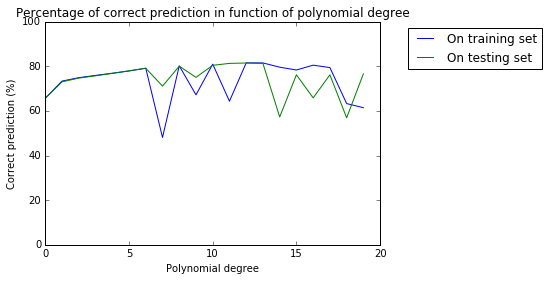

In [87]:
p = plt.plot(degrees, pred_RR_test_VEC, degrees, perc_correct_RR_VEC)
plt.title("Percentage of correct prediction in function of polynomial degree") 
plt.xlabel('Polynomial degree')
plt.ylabel('Correct prediction (%)')
plt.legend(p, ["On training set", "On testing set"], bbox_to_anchor=(1.5, 1))
plt.ylim([0, 100])
plt.show()

We observe that with a 7 or more degree polynomial, we are overfitting.

### Logistic regression

In [51]:
max_iters_LogR_test = 2000
gamma_LogR_test = 1.0e-10
method = 5

loss_LogR_test, weights_LogR_test = logistic_regression(y1, tX1, gamma_LogR_test, max_iters_LogR_test)
print("\nweights_LogR:\n",weights_LogR_test,"\n")

pred_LogR_test = prediction(y1, tX1, gamma_LogR_test, 0, max_iters_LogR_test, method)
print("pred_LogR = ", pred_LogR_test)


weights_LogR:
 [ -7.93971123e-03  -9.25427112e-01  -6.87095681e-01  -6.61222434e-01
  -1.67225941e-01  -1.29103044e-02  -1.00695125e+00  -5.13309675e-03
  -1.86704410e-02  -1.57261061e-01  -8.31681534e-01  -1.53710195e-02
   8.75789549e-03  -2.72906766e-03  -1.81113730e-01   7.07021183e-06
  -9.30049190e-05  -3.87601218e-01   2.48637077e-04  -2.40084245e-04
  -3.13451695e-01   4.10680696e-04  -1.25211521e+00  -4.67453228e-03
  -4.78044443e-01  -7.96808619e-05   1.75176394e-04  -3.92081664e-01
   1.14565931e-04  -9.08258862e-05  -2.62966530e-01] 

pred_LogR =  0.657165668663


In [52]:
y_pred_LogR_test = predict_labels(weights_LogR_test, tX2)
n_correct_LogR = np.count_nonzero((y_pred_LogR_test - y2) == 0)
perc_correct_LogR = n_correct_LogR/(N/2) * 100
perc_correct_LogR

65.6112

### Regularized logistic regression

In [91]:
max_iters_RLogR_test = 1000
lambda_RLogR_test = 1.0e-8
gamma_RLogR_test = 1.0e-10
method = 5

loss_RLogR_test, weights_RLogR_test = reg_logistic_regression(y1, tX1, gamma_RLogR_test, lambda_RLogR_test, max_iters_RLogR_test)
print("\nweights_RLogR:\n", weights_RLogR_test,"\n")

pred_RLogR_test = prediction(y1, tX1, gamma_RLogR_test, lambda_RLogR_test, max_iters_RLogR_test, 6)
print("pred_RLogR = ", pred_RLogR_test)


weights_RLogR:
 [ -3.97591135e-03  -4.63417801e-01  -3.43851231e-01  -3.31086769e-01
  -8.38949357e-02  -6.46798583e-03  -5.04951374e-01  -2.56499077e-03
  -9.34990276e-03  -7.87331013e-02  -4.16658730e-01  -7.69410972e-03
   4.38058657e-03  -1.36723968e-03  -9.07765961e-02   3.62428974e-06
  -4.64316411e-05  -1.94069099e-01   1.24478454e-04  -1.20333767e-04
  -1.56955876e-01   2.05426874e-04  -6.27166821e-01  -2.34213240e-03
  -2.39448596e-01  -3.98241840e-05   8.77391719e-05  -1.96338684e-01
   5.73464088e-05  -4.53979083e-05  -1.31813007e-01] 

pred_RLogR =  0.657165668663


In [92]:
y_pred_RLogR_test = predict_labels(weights_RLogR_test, tX2)
n_correct_RLogR = np.count_nonzero((y_pred_RLogR_test - y2) == 0)
perc_correct_RLogR = n_correct_RLogR/(N/2) * 100
perc_correct_RLogR

65.6112

## Training on the entire training set

### Linear regression - gradient descent

In [ ]:
max_iters_GD = 5000
gamma_GD = 1.0e-8
method = 1

loss_GD, weights_GD = least_squares_GD(y, tX_stand, gamma_GD, max_iters_GD)
pred_GD = prediction(y, tX_stand, gamma_GD, 0, max_iters_GD, method)

print("\nweights_GD:\n",weights_GD,"\n")
print("pred_GD = ", pred_GD)

### Linear regression - stochastic gradient descent

In [ ]:
max_iters_SGD = 1000
gamma_SGD = 1.0e-8
method = 2

loss_SGD, weights_SGD = least_squares_SGD(y, tX_stand, gamma_SGD, max_iters_SGD)
print("\nweights_SGD:\n",weights_SGD,"\n")

pred_SGD = prediction(y, tX_stand, gamma_SGD, 0, max_iters_SGD, method)
print("pred_SGD = ", pred_SGD)

### Least squares

In [ ]:
method = 3

tX_cleaned_TEST = tX_cleaned.copy()
w0 = np.ones([1,tX_cleaned_TEST.shape[0]])
tX_cleaned_TEST = np.insert(tX_cleaned_TEST, 0, w0, axis=1)

loss_LeastS, weights_LeastS = least_squares(y, tX_cleaned_TEST)
print("\nweights_LeastS:\n",weights_LeastS,"\n")

pred_LeastS = prediction(y, tX_cleaned_TEST, 0, 0, 0, method)
print("pred_LeastS = ", pred_LeastS)

### Ridge regression

In [27]:
lambda_RR = 5
method = 4

degree_RR = 12

tX_cleaned_TEST = tX_cleaned.copy()
w0 = np.ones([1,tX_cleaned_TEST.shape[0]])
tX_cleaned_TEST = np.insert(tX_cleaned_TEST, 0, w0, axis=1)

tX_poly_TEST = build_poly(tX_cleaned_TEST, degree_RR)

loss_RR, weights_RR = ridge_regression(y, tX_poly_TEST, lambda_RR)
# print("\nweights_RR:\n", weights_RR,"\n")

pred_RR = prediction(y, tX_poly_TEST, 0, lambda_RR, 0, method)
print("pred_RR = ", pred_RR)

pred_RR =  0.619521355228


### Logistic regression

In [ ]:
max_iters_LogR = 1000
gamma_LogR = 1.0e-6
method = 5

loss_LogR, weights_LogR = logistic_regression(y, tX_stand, gamma_LogR, max_iters_LogR)
print("\nweights_LogR:\n",weights_LogR,"\n")

pred_LogR = prediction(y, tX_stand, gamma_LogR, 0, max_iters_LogR, method)
print("pred_LogR = ", pred_LogR)

### Regularized logistic regression

In [ ]:
max_iters_RLogR = 1000
lambda_RLogR = 2
gamma_RLogR = 1.0e-8
method = 5

loss_RLogR, weights_RLogR = reg_logistic_regression(y, tX_stand, gamma_RLogR, lambda_RLogR, max_iters_RLogR)
print("\nweights_RLogR:\n",weights_RLogR,"\n")

pred_RLogR = prediction(y, tX_stand, gamma_RLogR, lambda_RLogR, max_iters_RLogR, 6)
print("pred_RLogR = ", pred_RLogR)

# Serparating the data by JET values

## Entire set

In [266]:
def separating_by_jet(tX):
    
    # JET 1
    tX0_index = tX[:, 22] == 0.0
    tX0 = tX[tX0_index]
    
    # JET 2
    tX1_index = tX[:, 22] == 1.0
    tX1 = tX[tX1_index]
    
    # JET 3
    tX2_index = tX[:, 22] == 2.0
    tX2 = tX[tX2_index]
    
    # JET 4
    tX3_index = tX[:, 22] == 3.0
    tX3 = tX[tX3_index]
    
    return tX0, tX0_index, tX1, tX1_index, tX2, tX2_index, tX3, tX3_index

In [358]:
def clean_data_jet(tX) :
    
    (nbrRows, nbrColumn) = tX.shape
    
    tX_cleaned, _ = clean_data(tX)
    tX_reformed = tX_cleaned.copy()
    nbrOfDelete = 0
    
    for iColumn in range(0, nbrColumn) :
        if np.isnan(tX_cleaned[:, iColumn]).all():
            tX_reformed = np.delete(tX_reformed, iColumn - nbrOfDelete, 1)
            nbrOfDelete = nbrOfDelete + 1
        
    return tX_reformed

In [458]:
tX_jet0, indexes_jet0, tX_jet1, indexes_jet1, tX_jet2, indexes_jet2, tX_jet3, indexes_jet3 = separating_by_jet(tX)
y_jet0 = y[indexes_jet0]
y_jet1 = y[indexes_jet1]
y_jet2 = y[indexes_jet2]
y_jet3 = y[indexes_jet3]
tX_cleaned_jet0 = clean_data_jet(tX_jet0)
tX_cleaned_jet1 = clean_data_jet(tX_jet1)
tX_cleaned_jet2 = clean_data_jet(tX_jet2)
tX_cleaned_jet3 = clean_data_jet(tX_jet3)

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [460]:
tX_cleaned_jet0_TEST = md.clean_data(tX_jet0)

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [461]:
df_jet0 = pd.concat([pd.DataFrame({'labels': y_jet0}), pd.DataFrame(tX_cleaned_jet0)], axis=1)
df_jet0.head(8)

,labels,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,-1.0,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,...,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0.0,0.0
1,-1.0,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,...,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0.0,0.0
2,-1.0,105.594,50.559,100.989,4.288,2.904,4.288,65.333,0.675,-1.366,...,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0.0,0.0
3,-1.0,111.452,86.240,79.692,27.201,2.338,27.201,81.734,1.750,-1.412,...,-0.866,2.878,52.016,0.126,-1.288,51.276,0.688,250.178,0.0,0.0
4,-1.0,82.488,31.663,64.128,8.232,2.823,8.232,58.649,1.303,-1.414,...,-0.654,-2.990,33.179,-1.665,-0.354,12.439,1.433,163.420,0.0,0.0
5,-1.0,111.452,109.412,14.398,17.323,0.472,17.323,62.565,1.774,-0.272,...,1.389,1.340,40.013,1.856,1.412,75.197,-1.583,198.616,0.0,0.0
6,1.0,111.026,32.096,75.271,23.067,3.205,23.067,69.649,1.276,-1.414,...,-1.107,-1.903,39.043,-1.944,1.191,19.959,2.415,122.176,0.0,0.0
7,1.0,127.861,50.953,77.267,26.967,2.833,26.967,79.503,1.586,1.401,...,-0.635,2.603,48.764,-0.343,-0.862,17.557,-2.975,211.720,0.0,0.0


In [462]:
df_jet0 = pd.concat([pd.DataFrame({'labels': y_jet0}), pd.DataFrame(tX_cleaned_jet0_TEST)], axis=1)
df_jet0.head(8)

,labels,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,-1.0,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,...,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0.0,0.0
1,-1.0,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,...,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0.0,0.0
2,-1.0,105.594,50.559,100.989,4.288,2.904,4.288,65.333,0.675,-1.366,...,2.433,-2.532,26.325,0.210,1.884,37.791,0.024,129.804,0.0,0.0
3,-1.0,111.452,86.240,79.692,27.201,2.338,27.201,81.734,1.750,-1.412,...,-0.866,2.878,52.016,0.126,-1.288,51.276,0.688,250.178,0.0,0.0
4,-1.0,82.488,31.663,64.128,8.232,2.823,8.232,58.649,1.303,-1.414,...,-0.654,-2.990,33.179,-1.665,-0.354,12.439,1.433,163.420,0.0,0.0
5,-1.0,111.452,109.412,14.398,17.323,0.472,17.323,62.565,1.774,-0.272,...,1.389,1.340,40.013,1.856,1.412,75.197,-1.583,198.616,0.0,0.0
6,1.0,111.026,32.096,75.271,23.067,3.205,23.067,69.649,1.276,-1.414,...,-1.107,-1.903,39.043,-1.944,1.191,19.959,2.415,122.176,0.0,0.0
7,1.0,127.861,50.953,77.267,26.967,2.833,26.967,79.503,1.586,1.401,...,-0.635,2.603,48.764,-0.343,-0.862,17.557,-2.975,211.720,0.0,0.0


In [333]:
test_values, _ = clean_data(tX_jet0)
TEST = pd.DataFrame(test_values)
TEST.head(8)

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,...,0.060,86.062,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,...,-0.871,53.131,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,105.594,50.559,100.989,4.288,NaN,NaN,NaN,2.904,4.288,65.333,...,0.024,129.804,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,111.452,86.240,79.692,27.201,NaN,NaN,NaN,2.338,27.201,81.734,...,0.688,250.178,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,82.488,31.663,64.128,8.232,NaN,NaN,NaN,2.823,8.232,58.649,...,1.433,163.420,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,111.452,109.412,14.398,17.323,NaN,NaN,NaN,0.472,17.323,62.565,...,-1.583,198.616,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6,111.026,32.096,75.271,23.067,NaN,NaN,NaN,3.205,23.067,69.649,...,2.415,122.176,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
7,127.861,50.953,77.267,26.967,NaN,NaN,NaN,2.833,26.967,79.503,...,-2.975,211.720,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [360]:
tX_cleaned_jet0.shape

(99913, 20)

In [361]:
tX_cleaned_jet1.shape

(77544, 23)

In [362]:
tX_cleaned_jet2.shape

(50379, 30)

In [363]:
tX_cleaned_jet3.shape

(22164, 30)

## Half set

In [433]:
tX1_jet0, indexes1_jet0, tX1_jet1, indexes1_jet1, tX1_jet2, indexes1_jet2, tX1_jet3, indexes1_jet3 = separating_by_jet(tX1)
tX2_jet0, indexes2_jet0, tX2_jet1, indexes2_jet1, tX2_jet2, indexes2_jet2, tX2_jet3, indexes2_jet3 = separating_by_jet(tX2)

y1_jet0 = y1[indexes1_jet0]
y1_jet1 = y1[indexes1_jet1]
y1_jet2 = y1[indexes1_jet2]
y1_jet3 = y1[indexes1_jet3]

y2_jet0 = y2[indexes2_jet0]
y2_jet1 = y2[indexes2_jet1]
y2_jet2 = y2[indexes2_jet2]
y2_jet3 = y2[indexes2_jet3]

tX1_cleaned_jet0 = clean_data_jet(tX1_jet0)
tX1_cleaned_jet1 = clean_data_jet(tX1_jet1)
tX1_cleaned_jet2 = clean_data_jet(tX1_jet2)
tX1_cleaned_jet3 = clean_data_jet(tX1_jet3)

tX2_cleaned_jet0 = clean_data_jet(tX2_jet0)
tX2_cleaned_jet1 = clean_data_jet(tX2_jet1)
tX2_cleaned_jet2 = clean_data_jet(tX2_jet2)
tX2_cleaned_jet3 = clean_data_jet(tX2_jet3)

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


## Training data for each JET

In [435]:
lambdas = [1e-10, 2e-10, 3e-10, 4e-10, 5e-10, 6e-10, 7e-10, 8e-10, 9e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-3, 1e-2, 1e-1, 1, 10]
degrees = range(0, 12)

### JET == 0.0

In [439]:
pred_jet0_VEC = np.zeros((len(lambdas)*len(degrees), 1))
i = 0

method = 4

tX_reformed_jet0 = tX_cleaned_jet0.copy()
w0 = np.ones([1,tX_reformed_jet0.shape[0]])
tX_reformed_jet0 = np.insert(tX_reformed_jet0, 0, w0, axis=1)

for deg in degrees:
    for lam in lambdas:

        tX_poly_jet0 = build_poly(tX_reformed_jet0, deg)

        loss_jet0, weights_jet0 = ridge_regression(y_jet0, tX_poly_jet0, lam)
        # print("\nweights_RR:\n", weights_jet0,"\n")

        pred_jet0 = prediction(y_jet0, tX_poly_jet0, 0, lam, 0, method)
        pred_jet0_VEC[i] = pred_jet0
        i = i + 1
        if pred_jet0 > 0.83 :
            print("prediction jet1 = ", pred_jet0, " with lambda: ", str(lam), " degree: ", str(deg))

prediction jet1 =  0.814108133396  with lambda:  1e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  2e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  3e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  4e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  5e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  6e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  7e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  8e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  9e-10  degree:  1
prediction jet1 =  0.814108133396  with lambda:  1e-09  degree:  1
prediction jet1 =  0.814074717637  with lambda:  1e-08  degree:  1
prediction jet1 =  0.814108133396  with lambda:  1e-07  degree:  1
prediction jet1 =  0.814074717637  with lambda:  1e-06  degree:  1
prediction jet1 =  0.814074717637  with lambda:  1e-05  degree:  1
prediction jet1 =  0.814007886119  with lambda:  0.001  degree

KeyboardInterrupt: 

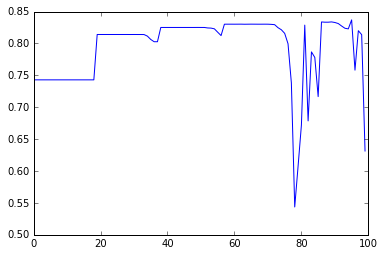

In [414]:
p = plt.plot(pred_jet0_VEC[:100])
plt.show()

In [448]:
lambda_jet0 = 6e-10
method = 4

degree_jet0 = 3

tX_reformed_jet0 = tX_cleaned_jet0.copy()
w0 = np.ones([1,tX_reformed_jet0.shape[0]])
tX_reformed_jet0 = np.insert(tX_reformed_jet0, 0, w0, axis=1)

tX_poly_jet0 = build_poly(tX_reformed_jet0, degree_jet0)

loss_jet0, weights_jet0 = ridge_regression(y_jet0, tX_poly_jet0, lambda_jet0)
# print("\nweights_RR:\n", weights_jet0,"\n")

pred_jet0 = prediction(y_jet0, tX_poly_jet0, 0, lambda_jet0, 0, method)
print("pred_RR = ", pred_jet0)

pred_RR =  0.830314776449


### JET == 1.0

In [449]:
pred_jet1_VEC = np.zeros((len(lambdas)*len(degrees), 1))
i = 0

method = 4

tX_reformed_jet1 = tX_cleaned_jet1.copy()
w0 = np.ones([1,tX_reformed_jet1.shape[0]])
tX_reformed_jet1 = np.insert(tX_reformed_jet1, 0, w0, axis=1)

for deg in degrees:
    for lam in lambdas:

        tX_poly_jet1 = build_poly(tX_reformed_jet1, deg)

        loss_jet1, weights_jet1 = ridge_regression(y_jet1, tX_poly_jet1, lam)
        # print("\nweights_RR:\n", weights_jet0,"\n")

        pred_jet1 = prediction(y_jet1, tX_poly_jet1, 0, lam, 0, method)
        pred_jet1_VEC[i] = pred_jet1
        i = i + 1
        if pred_jet1 > 0.799 :
            print("prediction jet1 = ", pred_jet1, " with lambda: ", str(lam), " degree: ", str(deg))

KeyboardInterrupt: 

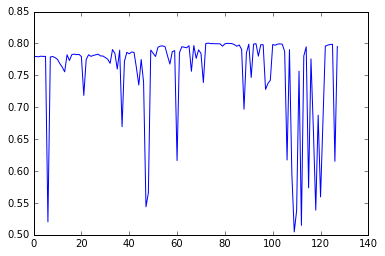

In [447]:
p = plt.plot(pred_jet1_VEC[100:250])
plt.show()

In [450]:
lambda_jet1 = 3e-10
method = 4

degree_jet1 = 9

tX_reformed_jet1 = tX_cleaned_jet1.copy()
w0 = np.ones([1,tX_reformed_jet1.shape[0]])
tX_reformed_jet1 = np.insert(tX_reformed_jet1, 0, w0, axis=1)

tX_poly_jet1 = build_poly(tX_reformed_jet1, degree_jet1)

loss_jet1, weights_jet1 = ridge_regression(y_jet1, tX_poly_jet1, lambda_jet1)
# print("\nweights_RR:\n", weights_jet1,"\n")

pred_jet1 = prediction(y_jet1, tX_poly_jet1, 0, lambda_jet1, 0, method)
print("pred_RR = ", pred_jet1)

pred_RR =  0.800585878603


### JET == 2.0

In [421]:
pred_jet2_VEC = np.zeros((len(lambdas)*len(degrees), 1))
i = 0

method = 4

tX_reformed_jet2 = tX_cleaned_jet2.copy()
w0 = np.ones([1,tX_reformed_jet2.shape[0]])
tX_reformed_jet2 = np.insert(tX_reformed_jet2, 0, w0, axis=1)


for deg in degrees:
    for lam in lambdas:

        tX_poly_jet2 = build_poly(tX_reformed_jet2, deg)

        loss_jet2, weights_jet2 = ridge_regression(y_jet2, tX_poly_jet2, lam)
        # print("\nweights_RR:\n", weights_jet0,"\n")

        pred_jet2 = prediction(y_jet2, tX_poly_jet2, 0, lam, 0, method)
        pred_jet2_VEC[i] = pred_jet2
        i = i + 1

        if pred_jet2 > 0.83 :
            print("prediction jet2 = ", pred_jet2, " with lambda: ", str(lam), " degree: ", str(deg))

prediction jet2 =  0.830403926511  with lambda:  1e-10  degree:  9
prediction jet2 =  0.830536578895  with lambda:  2e-10  degree:  9
prediction jet2 =  0.830470252703  with lambda:  3e-10  degree:  9
prediction jet2 =  0.830403926511  with lambda:  4e-10  degree:  9
prediction jet2 =  0.830602905087  with lambda:  5e-10  degree:  9
prediction jet2 =  0.830602905087  with lambda:  6e-10  degree:  9
prediction jet2 =  0.830735557472  with lambda:  7e-10  degree:  9
prediction jet2 =  0.830735557472  with lambda:  8e-10  degree:  9
prediction jet2 =  0.830735557472  with lambda:  9e-10  degree:  9
prediction jet2 =  0.830735557472  with lambda:  1e-09  degree:  9
prediction jet2 =  0.830536578895  with lambda:  1e-08  degree:  9
prediction jet2 =  0.830337600318  with lambda:  1e-07  degree:  9
prediction jet2 =  0.830138621742  with lambda:  1e-10  degree:  10
prediction jet2 =  0.830005969357  with lambda:  2e-10  degree:  10
prediction jet2 =  0.830403926511  with lambda:  3e-10  degr

LinAlgError: Singular matrix

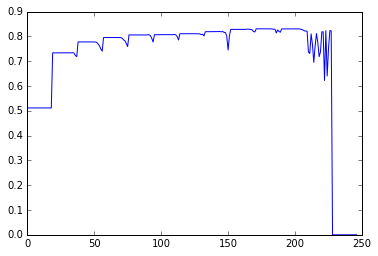

In [424]:
p = plt.plot(pred_jet2_VEC)
plt.show()

In [451]:
lambda_jet2 = 8e-10
method = 4

degree_jet2 = 9

tX_reformed_jet2 = tX_cleaned_jet2.copy()
w0 = np.ones([1,tX_reformed_jet2.shape[0]])
tX_reformed_jet2 = np.insert(tX_reformed_jet2, 0, w0, axis=1)

tX_poly_jet2 = build_poly(tX_reformed_jet2, degree_jet2)

loss_jet2, weights_jet2 = ridge_regression(y_jet2, tX_poly_jet2, lambda_jet2)
# print("\nweights_RR:\n", weights_jet2,"\n")

pred_jet2 = prediction(y_jet2, tX_poly_jet2, 0, lambda_jet2, 0, method)

print("pred_RR = ", pred_jet2)

pred_RR =  0.830735557472


### JET == 3.0

In [440]:
pred_jet3_VEC = np.zeros((len(lambdas)*len(degrees), 1))
i = 0

method = 4

tX_reformed_jet3 = tX_cleaned_jet3.copy()
w0 = np.ones([1,tX_reformed_jet3.shape[0]])
tX_reformed_jet3 = np.insert(tX_reformed_jet3, 0, w0, axis=1)

for deg in degrees:
    for lam in lambdas:

        tX_poly_jet3 = build_poly(tX_reformed_jet3, deg)

        loss_jet3, weights_jet3 = ridge_regression(y_jet3, tX_poly_jet3, lam)
        # print("\nweights_RR:\n", weights_jet0,"\n")

        pred_jet3 = prediction(y_jet3, tX_poly_jet3, 0, lam, 0, method)
        pred_jet3_VEC[i] = pred_jet3
        i = i + 1

        if pred_jet3 > 0.82 :
            print("prediction jet3 = ", pred_jet3, " with lambda: ", str(lam), " degree: ", str(deg))

prediction jet3 =  0.823257202568  with lambda:  1e-10  degree:  8
prediction jet3 =  0.823406478579  with lambda:  2e-10  degree:  8
prediction jet3 =  0.822958650545  with lambda:  3e-10  degree:  8
prediction jet3 =  0.823854306613  with lambda:  4e-10  degree:  8
prediction jet3 =  0.823705030602  with lambda:  5e-10  degree:  8
prediction jet3 =  0.823257202568  with lambda:  6e-10  degree:  8
prediction jet3 =  0.823406478579  with lambda:  7e-10  degree:  8
prediction jet3 =  0.824302134647  with lambda:  8e-10  degree:  8
prediction jet3 =  0.824302134647  with lambda:  9e-10  degree:  8
prediction jet3 =  0.824451410658  with lambda:  1e-09  degree:  8
prediction jet3 =  0.823107926556  with lambda:  1e-08  degree:  8
prediction jet3 =  0.823854306613  with lambda:  1e-07  degree:  8
prediction jet3 =  0.824302134647  with lambda:  1e-06  degree:  8
prediction jet3 =  0.824451410658  with lambda:  1e-05  degree:  8
prediction jet3 =  0.821615166443  with lambda:  0.1  degree: 

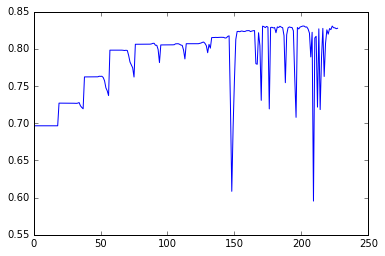

In [441]:
p = plt.plot(pred_jet3_VEC)
plt.show()

In [452]:
lambda_jet3 = 1e-7
method = 4

degree_jet3 = 10

tX_reformed_jet3 = tX_cleaned_jet3.copy()
w0 = np.ones([1,tX_reformed_jet3.shape[0]])
tX_reformed_jet3 = np.insert(tX_reformed_jet3, 0, w0, axis=1)

tX_poly_jet3 = build_poly(tX_reformed_jet3, degree_jet3)

loss_jet3, weights_jet3 = ridge_regression(y_jet3, tX_poly_jet3, lambda_jet3)
# print("\nweights_RR:\n", weights_jet3,"\n")

pred_jet3 = prediction(y_jet3, tX_poly_jet3, 0, lambda_jet3, 0, method)
print("pred_RR = ", pred_jet3)

pred_RR =  0.830571727123


### Testing set

In [382]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.shape

(568238, 30)

In [383]:
tX_test_jet0, indexes_test_jet0, tX_test_jet1, indexes_test_jet1, tX_test_jet2, indexes_test_jet2, tX_test_jet3, indexes_test_jet3 = separating_by_jet(tX_test)

tX_test_cleaned_jet0 = clean_data_jet(tX_test_jet0)
tX_test_cleaned_jet1 = clean_data_jet(tX_test_jet1)
tX_test_cleaned_jet2 = clean_data_jet(tX_test_jet2)
tX_test_cleaned_jet3 = clean_data_jet(tX_test_jet3)

/Users/davidrivollet/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [384]:
tX_test_reformed_jet0 = tX_test_cleaned_jet0.copy()
w0 = np.ones([1,tX_test_reformed_jet0.shape[0]])
tX_test_reformed_jet0 = np.insert(tX_test_reformed_jet0, 0, w0, axis=1)

tX_test_reformed_jet1 = tX_test_cleaned_jet1.copy()
w0 = np.ones([1,tX_test_reformed_jet1.shape[0]])
tX_test_reformed_jet1 = np.insert(tX_test_reformed_jet1, 0, w0, axis=1)

tX_test_reformed_jet2 = tX_test_cleaned_jet2.copy()
w0 = np.ones([1,tX_test_reformed_jet2.shape[0]])
tX_test_reformed_jet2 = np.insert(tX_test_reformed_jet2, 0, w0, axis=1)

tX_test_reformed_jet3 = tX_test_cleaned_jet3.copy()
w0 = np.ones([1,tX_test_reformed_jet3.shape[0]])
tX_test_reformed_jet3 = np.insert(tX_test_reformed_jet3, 0, w0, axis=1)

In [385]:
tX_test_poly_jet0 = build_poly(tX_test_reformed_jet0, degree_jet0)
tX_test_poly_jet1 = build_poly(tX_test_reformed_jet1, degree_jet1)
tX_test_poly_jet2 = build_poly(tX_test_reformed_jet2, degree_jet2)
tX_test_poly_jet3 = build_poly(tX_test_reformed_jet3, degree_jet3)

In [386]:
y_pred_jet0 = predict_labels(weights_jet0, tX_test_poly_jet0)
y_pred_jet1 = predict_labels(weights_jet1, tX_test_poly_jet1)
y_pred_jet2 = predict_labels(weights_jet2, tX_test_poly_jet2)
y_pred_jet3 = predict_labels(weights_jet3, tX_test_poly_jet3)

In [387]:
y_pred_final = np.ones((tX_test.shape[0], 1))
a = 0
b = 0
c = 0
d = 0
for i in range(0, y_pred_final.shape[0]):
    if indexes_test_jet0[i] == True:
        y_pred_final[i] = y_pred_jet0[a]
        a = a + 1
    if indexes_test_jet1[i] == True:
        y_pred_final[i] = y_pred_jet1[b]
        b = b + 1
    if indexes_test_jet2[i] == True:
        y_pred_final[i] = y_pred_jet2[c]
        c = c + 1
    if indexes_test_jet3[i] == True:
        y_pred_final[i] = y_pred_jet3[d]
        d = d + 1

In [388]:
y_pred_final.shape

(568238, 1)

In [389]:
OUTPUT_PATH = '../data/dataSubmission_RR.csv' 
create_csv_submission(ids_test, y_pred_final, OUTPUT_PATH)

# Generate predictions and save ouput in csv format for submission:

In [28]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
tX_test.shape

(568238, 30)

In [29]:
tX_test_cleaned, _ = clean_data(tX_test)

In [30]:
tX_test_cleaned_TEST = tX_test_cleaned.copy()
w0 = np.ones([1,tX_test_cleaned.shape[0]])
tX_test_cleaned_TEST = np.insert(tX_test_cleaned_TEST, 0, w0, axis=1)

In [31]:
tX_test_stand, mean_test, std_test = standardize(tX_test, mean_training, std_training)

In [ ]:
OUTPUT_PATH = '../data/dataSubmission_RR.csv' 
y_pred_RR = predict_labels(weights_RR, tX_test_stand)
create_csv_submission(ids_test, y_pred_RR, OUTPUT_PATH)

In [ ]:
OUTPUT_PATH = '../data/dataSubmission_LogR.csv' 
y_pred_LogR = predict_labels(weights_LogR, tX_test_stand)
create_csv_submission(ids_test, y_pred_LogR, OUTPUT_PATH)

In [ ]:
OUTPUT_PATH = '../data/dataSubmission_RLogR.csv' 
y_pred_RLogR = predict_labels(weights_RLogR_RLogR, tX_test_stand)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [ ]:
OUTPUT_PATH = '../data/dataSubmission_LS.csv' 
y_pred_LS = predict_labels(weights_LeastS, tX_test_cleaned_TEST)
create_csv_submission(ids_test, y_pred_LS, OUTPUT_PATH)

In [32]:
tX_test_poly_TEST = build_poly(tX_test_cleaned_TEST, degree_RR)

OUTPUT_PATH = '../data/dataSubmission_RR.csv' 
y_pred_RR = predict_labels(weights_RR, tX_test_poly_TEST)
create_csv_submission(ids_test, y_pred_RR, OUTPUT_PATH)